In [1]:
import torch
from torch import nn
import torch.nn.functional as F

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE


'cuda'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio
import torch
from datasets import load_dataset
from datasets import Audio as dsets_Audio
from torchaudio.pipelines import HUBERT_BASE
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
RATE = 16_000  # sample rate
print(DEVICE)
def simplify_audio_column(item):
    item["audio"] = item["audio"]["array"]
    return item

gtzan = load_dataset("marsyas/gtzan", split='all')
gtzan = gtzan.train_test_split(seed=42, shuffle=True, test_size=0.1, stratify_by_column = 'genre')
gtzan = gtzan.cast_column("audio", dsets_Audio(sampling_rate=RATE))
gtzan = gtzan.map(simplify_audio_column)
gtzan.set_format("torch", columns=["audio"], output_all_columns=True)

id2label_fn = gtzan["train"].features["genre"].int2str
id2label_fn(gtzan["train"][0]["genre"])
id2label = {
    str(i): id2label_fn(i)
    for i in range(len(gtzan["train"].features["genre"].names))
}
label2id = {v: k for k, v in id2label.items()}

/home/pvk/miniconda3/envs/audiobot/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


/home/pvk/miniconda3/envs/audiobot/lib/python3.12/site-packages/datasets/load.py:1486: FutureWarning: The repository for marsyas/gtzan contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/marsyas/gtzan
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Map: 100%|███████████████████████████████| 100/100 [00:03<00:00, 25.02 examples/s]


In [3]:
def collate_fn_trimmed(batch):
    audios = [x["audio"] for x in batch]
    seq_len = 480000
    # pad first seq to desired length
    audios[0] = nn.ConstantPad1d((0, seq_len - audios[0].shape[0]), 0.)(audios[0])
    # pad all seqs to desired length
    audios = pad_sequence(audios, batch_first=True, padding_value=0.)
    # trim to desired length
    audios = audios[:, :seq_len]
    targets = torch.tensor([x["genre"] for x in batch])
    return audios.unsqueeze(1), targets
BATCH_SIZE = 16
    
train_loader = DataLoader(gtzan["train"], batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=collate_fn_trimmed)
val_loader = DataLoader(gtzan["test"], batch_size=BATCH_SIZE, collate_fn=collate_fn_trimmed)
print(len(train_loader), len(val_loader))

a_batch = next(iter(train_loader))
print(a_batch[0].shape)
a_batch

57 7
torch.Size([16, 1, 480000])


(tensor([[[-0.0419, -0.0527, -0.0414,  ..., -0.0130,  0.0588,  0.1437]],
 
         [[-0.0757, -0.1066, -0.0787,  ...,  0.2208,  0.2447,  0.2579]],
 
         [[ 0.0738,  0.1052,  0.0957,  ...,  0.1590,  0.1299,  0.1231]],
 
         ...,
 
         [[ 0.0016, -0.0622,  0.0058,  ...,  0.7630,  0.6971,  0.6882]],
 
         [[ 0.1122,  0.1937,  0.1133,  ..., -0.0767, -0.0356, -0.0522]],
 
         [[ 0.0356,  0.0517,  0.0176,  ...,  0.0280,  0.0861, -0.0534]]]),
 tensor([3, 9, 9, 4, 1, 0, 0, 8, 8, 6, 7, 6, 4, 7, 4, 6]))

In [13]:
class CausalConv1d(nn.Module):
    """Causal 1D convolution. Outputs are the same shape as the inputs,
    and right-aligned so that the output at index n only depends on inputs
    at indices before n.
    """
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1,
                 bias=False, device=None, dtype=None):
        super().__init__()
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride=1,
                              padding=0, dilation=dilation, bias=bias,
                              device=device, dtype=dtype)
        if device is not None:
            self.to(device)
        
    def forward(self, x):
        # Left pad x
        x = F.pad(x, (self.dilation*(self.kernel_size-1), 0), mode="constant", value=0)
        # Now output is the same shape as x, and right-aligned
        return self.conv(x)
    
conv = CausalConv1d(1, 10, kernel_size=2, bias=False, dilation=2)

test_data = torch.cat((torch.zeros(1, 1, 3), torch.randn(1, 1, 4)), dim=2)
print(test_data)

print(test_data.shape, conv(test_data).shape)
conv(test_data)


tensor([[[ 0.0000,  0.0000,  0.0000, -0.0513,  0.1071,  1.1335, -0.2715]]])
torch.Size([1, 1, 7]) torch.Size([1, 10, 7])


tensor([[[ 0.0000,  0.0000,  0.0000, -0.0222,  0.0464,  0.5058, -0.1479],
         [ 0.0000,  0.0000,  0.0000,  0.0205, -0.0428, -0.4867,  0.1786],
         [ 0.0000,  0.0000,  0.0000, -0.0248,  0.0518,  0.5625, -0.1609],
         [ 0.0000,  0.0000,  0.0000, -0.0096,  0.0200,  0.1822,  0.0104],
         [ 0.0000,  0.0000,  0.0000, -0.0269,  0.0561,  0.5825, -0.1189],
         [ 0.0000,  0.0000,  0.0000,  0.0230, -0.0479, -0.5387,  0.1878],
         [ 0.0000,  0.0000,  0.0000, -0.0306,  0.0638,  0.6898, -0.1928],
         [ 0.0000,  0.0000,  0.0000,  0.0170, -0.0355, -0.3957,  0.1310],
         [ 0.0000,  0.0000,  0.0000, -0.0352,  0.0735,  0.7901, -0.2120],
         [ 0.0000,  0.0000,  0.0000, -0.0233,  0.0487,  0.5383, -0.1710]]],
       grad_fn=<ConvolutionBackward0>)

In [14]:
class SigmoidTanh(nn.Module):
    """Activation function consisting of a sigmoid on half of the channels,
    multiplied by a tanh on the other half.
    """
    def __init__(self):
        super().__init__()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        num_channels = x.shape[1]
        assert num_channels % 2 == 0
        return self.tanh(x[:, :num_channels//2]) * self.sigmoid(x[:, num_channels//2:])
    
sigmoidtanh = SigmoidTanh()
sigmoidtanh(conv(test_data))

tensor([[[ 0.0000,  0.0000,  0.0000, -0.0113,  0.0226,  0.1720, -0.0803],
         [ 0.0000,  0.0000,  0.0000,  0.0101, -0.0221, -0.3007,  0.0799],
         [ 0.0000,  0.0000,  0.0000, -0.0125,  0.0254,  0.2051, -0.0850],
         [ 0.0000,  0.0000,  0.0000, -0.0047,  0.0104,  0.1239,  0.0047],
         [ 0.0000,  0.0000,  0.0000, -0.0133,  0.0287,  0.3312, -0.0541]]],
       grad_fn=<MulBackward0>)

In [15]:
class ResidualBlock(nn.Module):
    """Block featuring a causal convolution layer, a sigmoid-tanh activation,
    and a 1x1 convolution that allows local mixing of features between channels.
    Produces two outputs, a "residual" and "skip" connection, with the skip
    connection intended to be sent to the output layer, and the residual
    connection intended to be sent to the next block.
    """
    def __init__(self, channels, kernel_size, dilation=1, bias=False,
                 device=None, dtype=None):
        super().__init__()
        self.conv = CausalConv1d(channels, 2*channels, kernel_size,
                                 dilation=dilation, bias=bias, device=device,
                                 dtype=dtype)
        self.actn = SigmoidTanh()
        self.onexone = nn.Conv1d(channels, channels, kernel_size=1, bias=bias,
                                 device=device, dtype=dtype)
        if device is not None:
            self.to(device)
            
    def forward(self, x):
        # Skip connection sent to final output
        # Res connection sent to next layer
        skip = self.onexone(self.actn(self.conv(x)))
        res = x + skip
        return res, skip
    
res_block = ResidualBlock(channels=10, kernel_size=2, dilation=2)

res_block(conv(test_data))

(tensor([[[ 0.0000,  0.0000,  0.0000, -0.0223,  0.0465,  0.5103, -0.1548],
          [ 0.0000,  0.0000,  0.0000,  0.0227, -0.0476, -0.5387,  0.1889],
          [ 0.0000,  0.0000,  0.0000, -0.0308,  0.0645,  0.7164, -0.2030],
          [ 0.0000,  0.0000,  0.0000, -0.0125,  0.0263,  0.2549, -0.0086],
          [ 0.0000,  0.0000,  0.0000, -0.0285,  0.0596,  0.6232, -0.1252],
          [ 0.0000,  0.0000,  0.0000,  0.0232, -0.0485, -0.5487,  0.1906],
          [ 0.0000,  0.0000,  0.0000, -0.0294,  0.0613,  0.6606, -0.1761],
          [ 0.0000,  0.0000,  0.0000,  0.0194, -0.0407, -0.4648,  0.1544],
          [ 0.0000,  0.0000,  0.0000, -0.0332,  0.0693,  0.7398, -0.2000],
          [ 0.0000,  0.0000,  0.0000, -0.0261,  0.0546,  0.6147, -0.2008]]],
        grad_fn=<AddBackward0>),
 tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -9.6042e-06,  3.5744e-05,
            4.5463e-03, -6.8677e-03],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  2.2245e-03, -4.7171e-03,
           -5.1982e-02,  

In [16]:
def default_dilation_schedule():
    """Generator for the dilation pattern used in the WaveNet paper."""
    dilation = 1
    while True:
        yield dilation
        dilation = 2 * dilation
        if dilation > 512:
            dilation = 1
            
def doubling_dilation_scheduler():
    """Continue to double dilations forever."""
    dilation = 1
    while True:
        yield dilation
        dilation = 2 * dilation


In [18]:
class ResidualStack(nn.Module):
    """A sequence of ResidualBlocks with different dilations.
    
    dilation_schedule should be an iterable yielding a sequence of dilations.
    By default, the schedule in the paper is used:
    1, 2, 4, ..., 512, 1, 2, 4, ..., 512, 1, 2, ...
    """
    def __init__(self, channels, num_blocks, kernel_size, 
                 dilation_schedule=None, bias=False, device=None, dtype=None):
        super().__init__()
        if dilation_schedule is None:
            dilation_schedule = default_dilation_schedule()
        self.blocks = []
        self.receptive_field = 1
        for dil in dilation_schedule:
            self.blocks.append(ResidualBlock(channels, kernel_size, dil, bias,
                                             device=device, dtype=dtype))
            self.receptive_field += dil*(kernel_size-1)
            if len(self.blocks) >= num_blocks:
                break
        self.blocks = nn.ModuleList(self.blocks)
        if device is not None:
            self.to(device)
        
    def forward(self, x):
        skip_out = torch.zeros_like(x)
        for block in self.blocks:
            x, skip = block(x)
            skip_out = skip_out + skip
        return skip_out
    
    
stack = ResidualStack(10, 5, 2)

print(stack.receptive_field)

stack(conv(test_data))

32


tensor([[[ 0.0000,  0.0000,  0.0000, -0.0004,  0.0009, -0.0215, -0.0067],
         [ 0.0000,  0.0000,  0.0000,  0.0007, -0.0005,  0.0040, -0.0265],
         [ 0.0000,  0.0000,  0.0000, -0.0040,  0.0107,  0.0853, -0.0816],
         [ 0.0000,  0.0000,  0.0000,  0.0006, -0.0034, -0.0324,  0.0230],
         [ 0.0000,  0.0000,  0.0000,  0.0004, -0.0023, -0.0076,  0.0038],
         [ 0.0000,  0.0000,  0.0000,  0.0049, -0.0073, -0.1579, -0.0597],
         [ 0.0000,  0.0000,  0.0000, -0.0058,  0.0090,  0.1196,  0.0470],
         [ 0.0000,  0.0000,  0.0000, -0.0021,  0.0068,  0.0439, -0.0647],
         [ 0.0000,  0.0000,  0.0000,  0.0088, -0.0181, -0.1843,  0.0398],
         [ 0.0000,  0.0000,  0.0000,  0.0035, -0.0090, -0.0930,  0.0270]]],
       grad_fn=<AddBackward0>)

In [19]:
def compand(x):
    """Mu-law companding transformation, which compresses a 16-bit depth
    signal to 8 bits. We use uint8 to make it easier to treat the outputs
    as classification labels.
    
    Args:
      x: torch.Tensor with values between -1 and 1. Generally speaking,
        this should be float32 obtained by scaling an int16 signal down
        to [-1, 1].
    Returns:
      torch.Tensor of the same shape as x, with torch.uint8 dtype
    """
    mu = 255
    out = torch.sign(x) * torch.log(1 + mu*torch.abs(x)) / np.log(1 + mu)
    return (128*out + 128).to(torch.uint8)

def inverse_compand(y):
    """Inverse of mu-law companding transformation, expanding an 8-bit integer
    signal to bit depth 16.
    
    Args:
      x: torch.Tensor with torch.uint8 dtype.
    Returns:
      torch.Tensor of the same shape as x, with torch.float dtype, lying in
        [-1, 1].
    """
    mu = 255
    z = y.float() / 128 - 1
    return torch.sign(z) * ((1 + mu)**torch.abs(z) - torch.ones_like(z)) / mu
    
    

torch.manual_seed(4)
x = torch.randint(-32767, 32768, size=(4, 1, 8), dtype=torch.int32)
print(x / 32768)
print(compand(x))
print(inverse_compand(compand(x)) * 32768)

tensor([[[-0.5309, -0.9434,  0.9204,  0.8670,  0.6290,  0.6598,  0.7917,
          -0.2680]],

        [[-0.8920, -0.9178,  0.7152, -0.7250, -0.8021, -0.1101, -0.3753,
          -0.2655]],

        [[ 0.4100,  0.2222,  0.8650,  0.0053, -0.1623, -0.7696,  0.3731,
           0.0548]],

        [[ 0.9753, -0.2285, -0.7401,  0.9895,  0.4583, -0.6377, -0.0508,
           0.2394]]])
tensor([[[ 31,  18, 237, 236, 229, 230, 234,  47]],

        [[ 19,  19, 232,  24,  22,  68,  39,  47]],

        [[219, 205, 236, 119,  59,  23, 217, 172]],

        [[239,  51,  24, 239, 221,  27,  85, 206]]], dtype=torch.uint8)
tensor([[[ -8459.7363, -14954.6104,  14315.1367,  13702.7734,  10084.6924,
           10536.8691,  12554.8330,  -4165.6172]],

        [[-14315.1367, -14315.1367,  11502.1680, -11502.1680, -12554.8330,
           -1600.4075,  -5944.2998,  -4165.6172]],

        [[  6493.9351,   3482.4077,  13702.7734,    -61.2731,  -2424.7966,
          -12017.1016,   5944.2998,    735.9528]],

        

Text(0.5, 1.0, 'Composition')

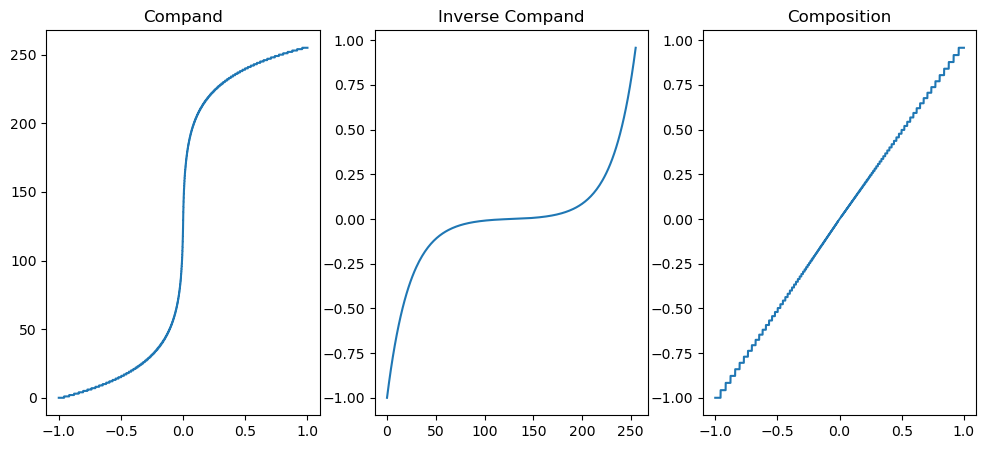

In [132]:
import matplotlib.pyplot as plt
xs = torch.arange(-32767, 32768)
xs_scaled = xs / 32768
ys = compand(xs_scaled)
zs = inverse_compand(ys)
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
axs[0].plot(xs_scaled, ys)
axs[0].set_title("Compand")
axs[1].plot(ys, zs)
axs[1].set_title("Inverse Compand")
axs[2].plot(xs_scaled, zs)
axs[2].set_title("Composition")

In [20]:
class WaveNetGenerativeHead(nn.Module):
    """Receive the sum of skip connections from the ResBlock layers.
    Produce logits for next audio sample, taken as one of 256 companded
    classes.
    
    For a generative model, the output will have the same sequence length as
    the input. We can view it as a sequence of predictions, one for each
    timestep, which is then evaluated against the inputs shifted 1 timestep
    backwards.
    """
    def __init__(self, channels):
        super().__init__()
        self.steps = nn.Sequential(
            nn.ReLU(),
            # Downsample to 256 classes
            nn.Conv1d(channels, 256, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=1),
            # Outputs treated as logits
        )
        
    def forward(self, x):
        return self.steps(x)
    
res_block(conv(test_data))[1].shape

gen_head = WaveNetGenerativeHead(10)
gen_head(res_block(conv(test_data))[1]).shape
            
    
    

torch.Size([1, 256, 7])

In [21]:
class WaveNetGenerative(nn.Module):
    """WaveNet architecture for generating raw audio."""
    def __init__(self, channels, num_blocks, kernel_size,
                 dilation_schedule=None, bias=False, device=None, dtype=None):
        super().__init__()
        self.input = CausalConv1d(1, channels, kernel_size, bias=bias,
                                  device=device, dtype=dtype)
        self.res_stack = ResidualStack(channels, num_blocks, kernel_size,
                                       dilation_schedule, bias=bias,
                                       device=device, dtype=dtype)
        self.output = WaveNetGenerativeHead(channels)
        
        self.receptive_field = self.res_stack.receptive_field
        if device is None:
            device = torch.device(DEVICE)
        self.device = device
        self.to(device)
        
    def forward(self, x):
        # x in shape [batch, seq]
        x = x.unsqueeze(1)
        # Return in shape [batch, seq, logit]
        return self.output(self.res_stack(self.input(x))).transpose(1, 2)
    
    def generate(self, start_audio, num_new_samples):
        # Assume start_audio is a batch
        out_audio = torch.cat([
            start_audio,
            torch.zeros(start_audio.shape[0], num_new_samples, device=self.device)
        ], dim=1)
        for i in range(num_new_samples):
            # Restrict to samples visible by the model
            start_idx = max(0, start_audio.shape[1] + i - self.receptive_field)
            audio = out_audio[:, start_idx:start_audio.shape[1]+i]
            next_sample_logits = self(audio)[:, -1, :]
            next_sample_prob = F.softmax(next_sample_logits, dim=1)
            next_sample = inverse_compand(torch.multinomial(next_sample_prob, 1))
            out_audio[:, start_audio.shape[1]+i] = next_sample.squeeze()
        return out_audio
        
        
        
    
wavenet = WaveNetGenerative(10, 6, 2, device=DEVICE)

len(song)
foo = song[:32000]
Audio(foo, rate=RATE)

extended = wavenet.generate(foo.unsqueeze(0).to(DEVICE), 32000)
Audio(extended[0].cpu(), rate=RATE)

# batch = torch.stack([song[:12], song[25:37], song[100:112]], dim=0)
# wavenet.generate(batch, 13).shape



NameError: name 'song' is not defined

In [147]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio
import torch
from datasets import load_dataset
from datasets import Audio as dsets_Audio
from torchaudio.pipelines import HUBERT_BASE
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
RATE = 16_000  # sample rate
print(DEVICE)
def simplify_audio_column(item):
    item["audio"] = item["audio"]["array"]
    return item

gtzan = load_dataset("marsyas/gtzan", split='all')
gtzan = gtzan.train_test_split(seed=42, shuffle=True, test_size=0.1, stratify_by_column = 'genre')
gtzan = gtzan.cast_column("audio", dsets_Audio(sampling_rate=RATE))
gtzan = gtzan.map(simplify_audio_column)
gtzan.set_format("torch", columns=["audio"], output_all_columns=True)
id2label_fn = gtzan["train"].features["genre"].int2str
id2label_fn(gtzan["train"][0]["genre"])
id2label = {
    str(i): id2label_fn(i)
    for i in range(len(gtzan["train"].features["genre"].names))
}
label2id = {v: k for k, v in id2label.items()}


cuda


tensor(-1.0528) tensor(0.9599)


In [47]:
import random
class SongsLoader():
    def __init__(self, dset, num_samples, batch_size):
        self.dset = dset
        self.num_samples = num_samples
        self.batch_size = batch_size
        
    def get_batch(self):
        batch = torch.zeros(self.batch_size, self.num_samples)
        labels = torch.zeros(self.batch_size, dtype=torch.long)
        for i in range(self.batch_size):
            song_idx = random.randrange(len(self.dset))
            song = self.dset[song_idx]
            start = random.randint(0, len(song["audio"]) - self.num_samples)
            batch[i] = song["audio"][start:start + self.num_samples]
            labels[i] = song["genre"]
        return batch, labels
    
def prep_batch_generative(batch):
    """Given a batch, get a pair (batch, targets). The targets are the batch,
    shifted left by 1, and converted to one of 256 classes per sample by
    companding. 
    
    Note that one sample gets dropped: a dataloader producing a sequence length
    of 9 is needed for a model that takes sequences of length 8.
    """
    tens = batch[:, :-1]
    targ = compand(batch[:, 1:])
    return tens, targ

train_loader = SongsLoader(gtzan["train"], 10001, 16)
test_loader = SongsLoader(gtzan["train"], 10001, 16)
batch = train_loader.get_batch()
tens, targ = prep_batch_generative(batch[0])
tens.shape, targ.shape
tens, targ, inverse_compand(targ)

(tensor([[ 0.0215,  0.0742,  0.0768,  ...,  0.5671,  0.5523,  0.5017],
         [-0.0260, -0.0306, -0.0349,  ...,  0.0293,  0.0323,  0.0370],
         [ 0.0282,  0.0428,  0.0366,  ..., -0.0137, -0.0484, -0.0262],
         ...,
         [ 0.0210,  0.0240,  0.0097,  ...,  0.0137,  0.0144,  0.0104],
         [ 0.4407,  0.4188,  0.2492,  ..., -0.2638, -0.2259, -0.1602],
         [-0.0611, -0.0674, -0.0991,  ..., -0.0403,  0.2214, -0.1930]]),
 tensor([[197, 197, 193,  ..., 242, 240, 236],
         [ 77,  75,  72,  ..., 179, 182, 184],
         [185, 181,  53,  ...,  68,  80,  88],
         ...,
         [173, 156, 176,  ..., 163, 157, 172],
         [236, 224, 207,  ...,  34,  41,  47],
         [ 61,  52,  61,  ..., 221,  37,  46]], dtype=torch.uint8),
 tensor([[ 0.0740,  0.0740,  0.0616,  ...,  0.5435,  0.4980,  0.4182],
         [-0.0318, -0.0350, -0.0404,  ...,  0.0318,  0.0368,  0.0404],
         [ 0.0424,  0.0350, -0.0971,  ..., -0.0488, -0.0275, -0.0183],
         ...,
         [ 0.0

In [294]:
wavenet.receptive_field

2047

In [293]:
idx = 225
song = gtzan['train'][idx]['audio']
print(song.min(), song.max())
Audio(song, rate=RATE)
foo = song[:32000]
Audio(foo, rate=RATE)

extended = wavenet.generate(foo.unsqueeze(0).to(DEVICE), 32000)
Audio(extended[0].cpu(), rate=RATE)

tensor(-1.0528) tensor(0.9599)


RuntimeError: Given input size: (12x1x2047). Calculated output size: (12x1x0). Output size is too small

In [24]:
class WaveNetClassifierHead(nn.Module):
    def __init__(self, channels, downsample, num_classes):
        super().__init__()
        self.steps = nn.Sequential(
            # Not quite the same as the paper (which is underspecified, anyway)
            # I put a conv before the ReLU
            nn.Conv1d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AvgPool1d(downsample),
            nn.ReLU(),
            nn.Conv1d(channels, num_classes, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(num_classes, num_classes, kernel_size=1),
        )
        
    def forward(self, x):
        return self.steps(x)
    
class WaveNetDiscriminative(nn.Module):
    """WaveNet architecture for classifying audio."""
    def __init__(self, channels, num_blocks, kernel_size, downsample, 
                 num_classes, dilation_schedule=None, bias=False, device=None,
                 dtype=None):
        super().__init__()
        self.input = CausalConv1d(1, channels, kernel_size, bias=bias,
                                  device=device, dtype=dtype)
        self.res_stack = ResidualStack(channels, num_blocks, kernel_size,
                                       dilation_schedule, bias=bias,
                                       device=device, dtype=dtype)
        self.output = WaveNetClassifierHead(channels, downsample, num_classes)
        
        self.receptive_field = self.res_stack.receptive_field
        if device is None:
            device = torch.device(DEVICE)
        self.device = device
        self.to(device)
        
    def forward(self, x):
        # x in shape [batch, seq]
        x = x.unsqueeze(1)
        # Return in shape [batch, seq, logit]
        return self.output(self.res_stack(self.input(x))).transpose(1, 2)
    
class WaveNetDualTask(nn.Module):
    def __init__(self, channels, num_blocks, kernel_size, downsample, 
                 num_classes, dilation_schedule=None, bias=False, device=None,
                 dtype=None):
        super().__init__()
        self.input = CausalConv1d(1, channels, kernel_size, bias=bias,
                                  device=device, dtype=dtype)
        self.res_stack = ResidualStack(channels, num_blocks, kernel_size,
                                       dilation_schedule, bias=bias,
                                       device=device, dtype=dtype)
        self.gen_output = WaveNetGenerativeHead(channels)
        self.disc_output = WaveNetClassifierHead(channels, downsample, num_classes)
        
        self.receptive_field = self.res_stack.receptive_field
        if device is None:
            device = torch.device(DEVICE)
        self.device = device
        self.to(device)
        
    def forward(self, x):
        # x in shape [batch, seq]
        x = x.unsqueeze(1)
        res_out = self.res_stack(self.input(x))
        disc_out = self.disc_output(res_out).transpose(1, 2)
        gen_out = self.gen_output(res_out).transpose(1, 2)
        return gen_out, disc_out
    
    def generate(self, start_audio, num_new_samples):
        # Assume start_audio is a batch
        out_audio = torch.cat([
            start_audio,
            torch.zeros(start_audio.shape[0], num_new_samples, device=self.device)
        ], dim=1)
        for i in range(num_new_samples):
            # Restrict to samples visible by the model
            start_idx = max(0, start_audio.shape[1] + i - self.receptive_field)
            audio = out_audio[:, start_idx:start_audio.shape[1]+i]
            next_sample_logits = self(audio)[0][:, -1, :]
            next_sample_prob = F.softmax(next_sample_logits, dim=1)
            next_sample = inverse_compand(torch.multinomial(next_sample_prob, 1))
            out_audio[:, start_audio.shape[1]+i] = next_sample.squeeze()
        return out_audio
            
    
    

In [307]:
from tqdm.auto import tqdm
NUM_CHANNELS = 12
NUM_BLOCKS = 16
KERNEL_SIZE = 2
DOWNSAMPLE = 65536
NUM_CLASSES = 10
TRAIN_STEPS = 10_000
EVAL_PERIOD = 1_000
EVAL_STEPS = 500
SEQ_LENGTH = 65536
BATCH_SIZE = 16
OPTIMIZER = torch.optim.AdamW
LR = 1e-3
wavenet = WaveNetDualTask(NUM_CHANNELS, NUM_BLOCKS, KERNEL_SIZE, DOWNSAMPLE, NUM_CLASSES, dilation_schedule=doubling_dilation_scheduler())
train_loader = SongsLoader(gtzan["train"], SEQ_LENGTH+1, BATCH_SIZE)
valid_loader = SongsLoader(gtzan["test"], SEQ_LENGTH+1, BATCH_SIZE)
optimizer = OPTIMIZER(wavenet.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
print(wavenet.receptive_field)

65536


In [308]:
@torch.no_grad()
def estimate_loss(model, num_eval_steps):
    model.eval()
    losses = {'train_gen': 0, 'train_disc': 0, 'valid_gen': 0, 'valid_disc': 0,
              'train_acc': 0, 'valid_acc': 0}
    loaders = {'train': train_loader, 'valid': valid_loader}
    train_loss = 0
    valid_loss = 0
    for _ in range(num_eval_steps):
        for split in ["train", "valid"]:
            batch = loaders[split].get_batch()
            tens, targ = prep_batch_generative(batch[0])
            gen_logits, disc_logits = model(tens.to(DEVICE))
            losses[split+'_gen'] += criterion(gen_logits.reshape(-1, 256),
                                              targ.flatten().to(DEVICE)).item() / num_eval_steps
            
            labels = batch[1].to(DEVICE)
            losses[split+'_disc'] += criterion(disc_logits.reshape(-1, NUM_CLASSES),
                                               labels).item() / num_eval_steps
            preds = torch.argmax(disc_logits.reshape(-1, NUM_CLASSES), dim=1)
            losses[split+'_acc'] += (preds == labels).sum().item() / (len(labels)*num_eval_steps)
    return losses
    
wavenet.train()
for i in tqdm(range(TRAIN_STEPS)):
    if i % EVAL_PERIOD == 0 or i + 1 == TRAIN_STEPS:
        wavenet.eval()
        losses = estimate_loss(wavenet, EVAL_STEPS)
        print(f"Step {i:>5} | Train: gen loss {losses['train_gen']:.3f}, disc loss {losses['train_disc']:.3f}, " +
              f"disc acc {losses['train_acc']:.3f}" +
              f" | Valid: gen loss {losses['valid_gen']:.3f}, disc loss {losses['valid_disc']:.3f}, " +
              f"disc acc {losses['valid_acc']:.3f}")
        wavenet.train()
        
    batch = train_loader.get_batch()
    tens, targ = prep_batch_generative(batch[0])
    labels = batch[1].to(DEVICE)
    gen_logits, disc_logits = wavenet(tens.to(DEVICE))
    gen_loss = criterion(gen_logits.reshape(-1, 256), targ.flatten().to(DEVICE))
    disc_loss = criterion(disc_logits.reshape(-1, NUM_CLASSES), labels)
    disc_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    

  0%|          | 0/10000 [00:00<?, ?it/s]

Step     0 | Train: gen loss 5.550, disc loss 2.319, disc acc 0.093 | Valid: gen loss 5.550, disc loss 2.318, disc acc 0.125
Step  1000 | Train: gen loss 5.740, disc loss 1.767, disc acc 0.317 | Valid: gen loss 5.744, disc loss 1.746, disc acc 0.267
Step  2000 | Train: gen loss 5.782, disc loss 1.640, disc acc 0.356 | Valid: gen loss 5.778, disc loss 1.621, disc acc 0.341
Step  3000 | Train: gen loss 5.809, disc loss 1.484, disc acc 0.445 | Valid: gen loss 5.813, disc loss 1.427, disc acc 0.421
Step  4000 | Train: gen loss 5.851, disc loss 1.448, disc acc 0.461 | Valid: gen loss 5.851, disc loss 1.434, disc acc 0.423
Step  5000 | Train: gen loss 5.831, disc loss 1.378, disc acc 0.493 | Valid: gen loss 5.834, disc loss 1.364, disc acc 0.446
Step  6000 | Train: gen loss 5.869, disc loss 1.375, disc acc 0.482 | Valid: gen loss 5.865, disc loss 1.331, disc acc 0.421
Step  7000 | Train: gen loss 5.841, disc loss 1.244, disc acc 0.552 | Valid: gen loss 5.843, disc loss 1.303, disc acc 0.498


In [309]:
torch.save(wavenet.state_dict(), "wavenet_disc_only.pth")

In [311]:
wavenet2 = WaveNetDualTask(NUM_CHANNELS, NUM_BLOCKS, KERNEL_SIZE, DOWNSAMPLE, NUM_CLASSES, dilation_schedule=doubling_dilation_scheduler())
train_loader = SongsLoader(gtzan["train"], SEQ_LENGTH+1, BATCH_SIZE)
valid_loader = SongsLoader(gtzan["test"], SEQ_LENGTH+1, BATCH_SIZE)
optimizer = OPTIMIZER(wavenet.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
print(wavenet2.receptive_field)
    
wavenet2.train()
TRAIN_STEPS = 50_000
for i in tqdm(range(TRAIN_STEPS)):
    if i % EVAL_PERIOD == 0 or i + 1 == TRAIN_STEPS:
        wavenet.eval()
        losses = estimate_loss(wavenet, EVAL_STEPS)
        print(f"Step {i:>5} | Train: gen loss {losses['train_gen']:.3f}, disc loss {losses['train_disc']:.3f}, " +
              f"disc acc {losses['train_acc']:.3f}" +
              f" | Valid: gen loss {losses['valid_gen']:.3f}, disc loss {losses['valid_disc']:.3f}, " +
              f"disc acc {losses['valid_acc']:.3f}")
        wavenet.train()
        
    batch = train_loader.get_batch()
    tens, targ = prep_batch_generative(batch[0])
    labels = batch[1].to(DEVICE)
    gen_logits, disc_logits = wavenet(tens.to(DEVICE))
    gen_loss = criterion(gen_logits.reshape(-1, 256), targ.flatten().to(DEVICE))
    disc_loss = criterion(disc_logits.reshape(-1, NUM_CLASSES), labels)
    loss = gen_loss + disc_loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
torch.save(wavenet.state_dict(), "wavenet_disc_and_gen.pth")

65536


  0%|          | 0/50000 [00:00<?, ?it/s]

Step     0 | Train: gen loss 5.870, disc loss 1.172, disc acc 0.578 | Valid: gen loss 5.869, disc loss 1.203, disc acc 0.539
Step  1000 | Train: gen loss 4.404, disc loss 1.246, disc acc 0.554 | Valid: gen loss 4.442, disc loss 1.312, disc acc 0.519
Step  2000 | Train: gen loss 4.259, disc loss 1.203, disc acc 0.567 | Valid: gen loss 4.286, disc loss 1.279, disc acc 0.505
Step  3000 | Train: gen loss 4.167, disc loss 1.174, disc acc 0.577 | Valid: gen loss 4.196, disc loss 1.244, disc acc 0.533
Step  4000 | Train: gen loss 4.084, disc loss 1.141, disc acc 0.587 | Valid: gen loss 4.113, disc loss 1.204, disc acc 0.524
Step  5000 | Train: gen loss 4.030, disc loss 1.103, disc acc 0.611 | Valid: gen loss 4.050, disc loss 1.137, disc acc 0.561
Step  6000 | Train: gen loss 3.973, disc loss 1.108, disc acc 0.618 | Valid: gen loss 3.992, disc loss 1.156, disc acc 0.586
Step  7000 | Train: gen loss 3.925, disc loss 1.074, disc acc 0.622 | Valid: gen loss 3.926, disc loss 1.117, disc acc 0.578


In [318]:
idx = 225
song = gtzan['train'][idx]['audio']
print(song.min(), song.max())
Audio(song, rate=RATE)
foo = song[:65536]
Audio(foo, rate=RATE)
print(foo.shape)

extended = wavenet.generate(foo.unsqueeze(0).to(DEVICE), 65536)

tensor(-1.0528) tensor(0.9599)
torch.Size([65536])


In [319]:
Audio(extended[0].cpu(), rate=RATE)

In [55]:
NUM_CHANNELS = 12
NUM_BLOCKS = 16
KERNEL_SIZE = 2
DOWNSAMPLE = 65536
NUM_CLASSES = 10
TRAIN_STEPS = 10_000
EVAL_PERIOD = 1_000
EVAL_STEPS = 500
SEQ_LENGTH = 65536
BATCH_SIZE = 16
OPTIMIZER = torch.optim.AdamW
LR = 1e-3
criterion = nn.CrossEntropyLoss()
train_loader = SongsLoader(gtzan["train"], SEQ_LENGTH+1, BATCH_SIZE)
valid_loader = SongsLoader(gtzan["test"], SEQ_LENGTH+1, BATCH_SIZE)
wavenet2 = WaveNetDualTask(NUM_CHANNELS, NUM_BLOCKS, KERNEL_SIZE, DOWNSAMPLE, NUM_CLASSES, dilation_schedule=doubling_dilation_scheduler())
wavenet2.load_state_dict(torch.load("../../audiobot-bak/models/wavenet_disc_and_gen.pth"))
wavenet2.to(DEVICE);

In [72]:
from sklearn.metrics import accuracy_score, f1_score
num_eval_steps = 1000
loss = acc = f1 = 0
for _ in range(num_eval_steps):
    batch = valid_loader.get_batch()
    tens, targ = prep_batch_generative(batch[0])
    with torch.inference_mode():
        _, disc_logits = wavenet2(tens.to(DEVICE))
        disc_logits.squeeze_(1)
    labels = batch[1]
    disc_preds = disc_logits.argmax(dim=1).cpu()
    loss += criterion(disc_logits.cpu(), labels).item()
    acc += accuracy_score(labels, disc_preds)
    f1 += f1_score(labels, disc_preds, average="macro")

acc /= num_eval_steps
f1 /= num_eval_steps
loss /= num_eval_steps

print(acc, f1, loss)


0.6685625 0.575412933585374 1.1193307506516577
